In [132]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload 
reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

In [133]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

In [227]:
nmax_f = 50
φ_ext_values =np.concatenate(([0.5],  0.5  + np.geomspace(1e-5, 0.5, 100)))
n_eig = 40

In [228]:
fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, nmax_f=nmax_f)
H0  = fluxonium.hamiltonian()
E0, ψ0 = sq_ext.diag(H0, n_eig, remove_ground=True, fix_phase=True)

In [282]:
E = np.zeros([len(φ_ext_values), n_eig])
ψ = np.zeros([len(φ_ext_values), nmax_f, n_eig], dtype='complex')
H = np.zeros([len(φ_ext_values), nmax_f, nmax_f], dtype='complex')

loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H[i] = fluxonium.hamiltonian()
    E[i] , ψ[i] = sq_ext.diag(H[i], n_eig, remove_ground=True, fix_phase=True)


In [283]:
overlap = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex')
H_in_ψ0 = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex') 
for i in range(len(φ_ext_values)) :
    overlap[i] = ψ0.conj().T  @ ψ[i]
    H_in_ψ0[i] = overlap[i] @ np.diag(E[i]) @ overlap[i].conj().T
    # H_in_ψ0[i] = ψ0.conj().T @ H[i].__array__() @ ψ0 / 2/ np.pi / 1e9

### Fluxonium eigensates expressed in the basis at frustration

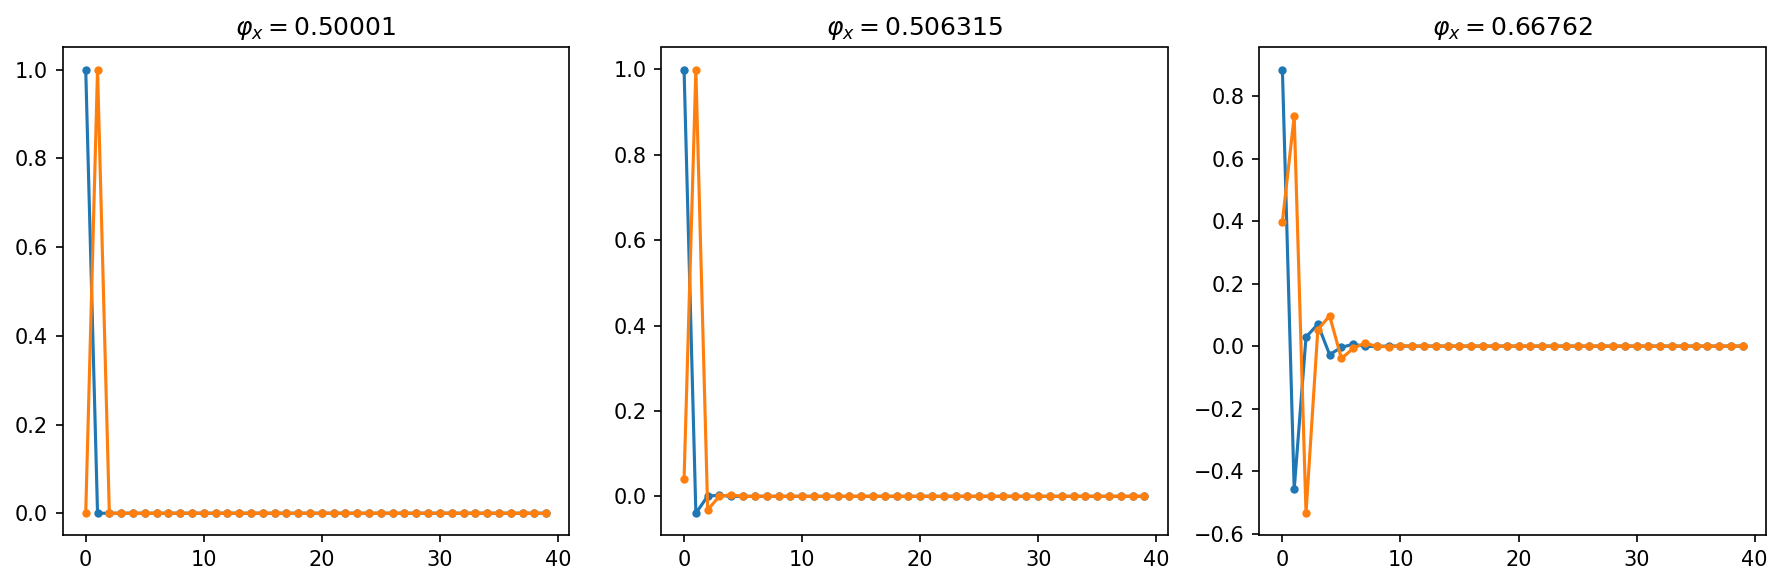

In [284]:
φ_ext_indices = [1, 60, 90]

fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(overlap[φ_ext_index,:,:2],'.-')
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')

fig.tight_layout()

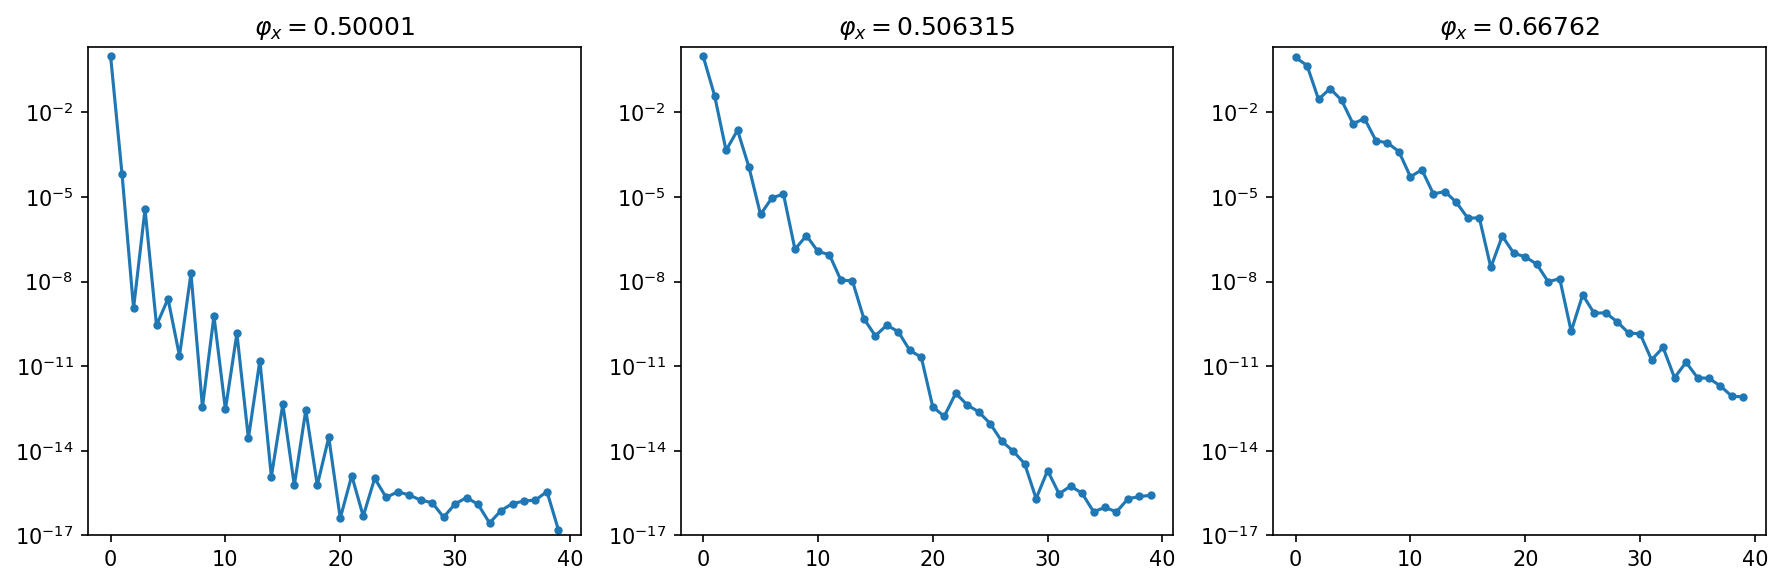

In [285]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(np.abs(overlap[φ_ext_index,:,0]),'.-')
    ax.set_yscale('log')
    ax.set_ylim([1e-17,2])
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    
fig.tight_layout()

### Fluxonium hamiltonian expressed in the basis at frustration

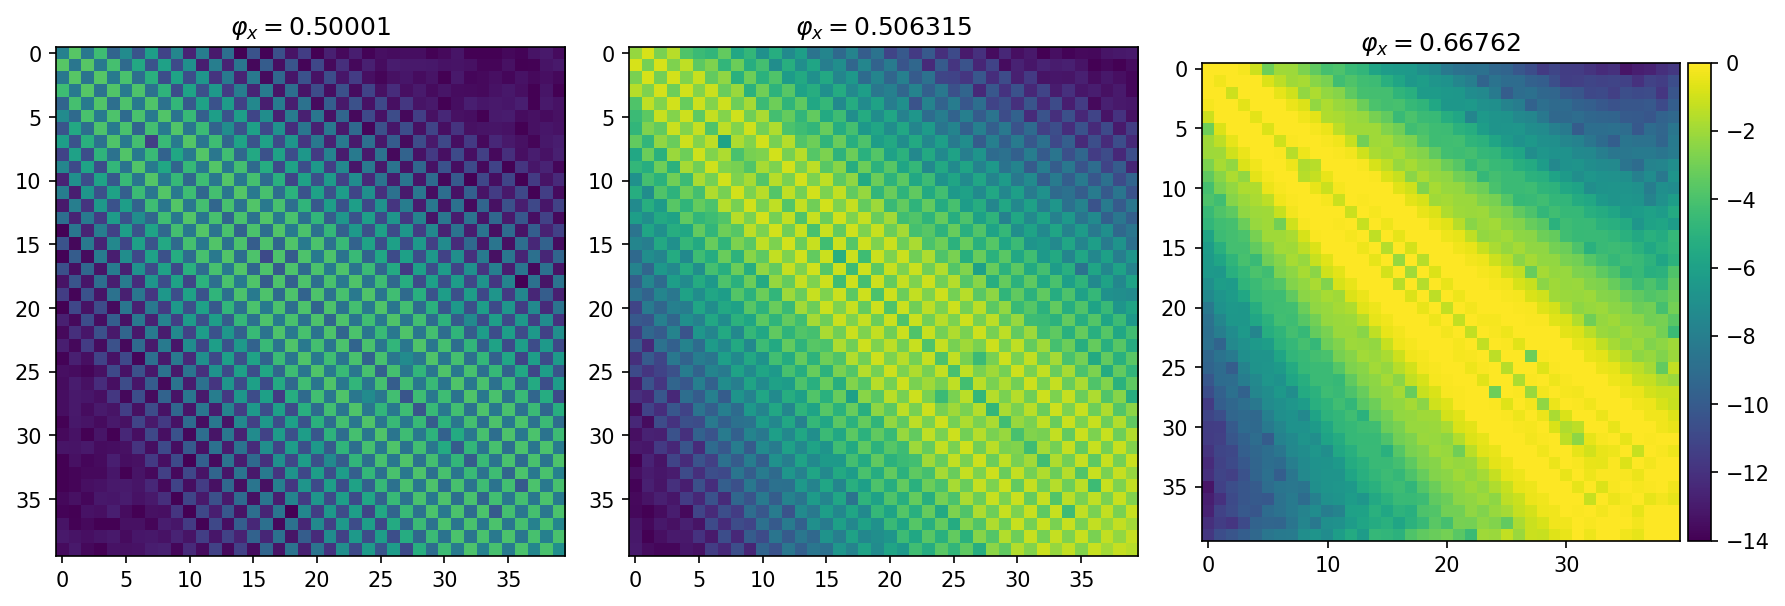

In [286]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
ticks=np.arange(-10,0)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    c = ax.imshow(np.log10(np.abs(H_in_ψ0[φ_ext_index]-np.diag(E[φ_ext_index]))),vmin=-14, vmax=0)
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    
figs.colorbar(c)  
fig.tight_layout()

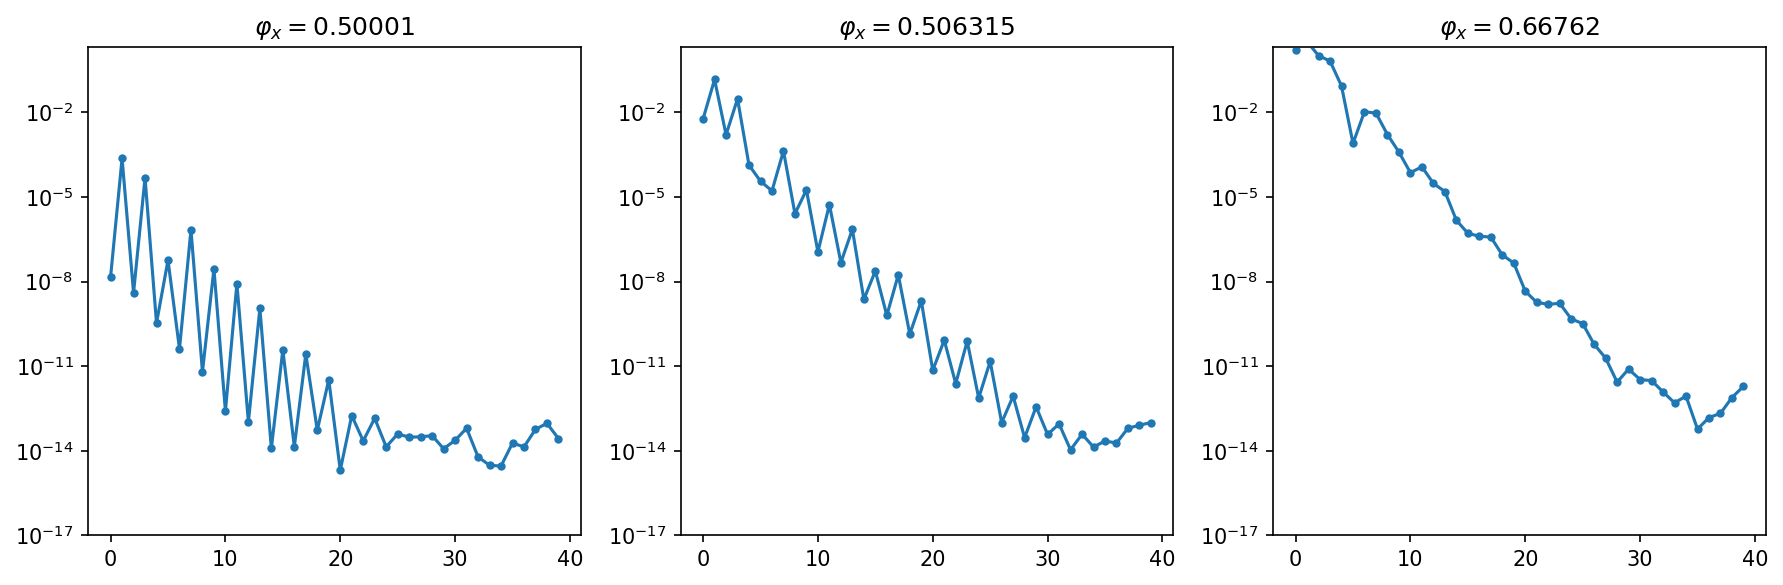

In [287]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(np.abs(H_in_ψ0[φ_ext_index,:,0]),'.-')
    ax.set_yscale('log')
    ax.set_ylim([1e-17,2])
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    
fig.tight_layout()

### Error in the spectrum of the fluxonium in the basis at frustration (with progressively cropped basis)

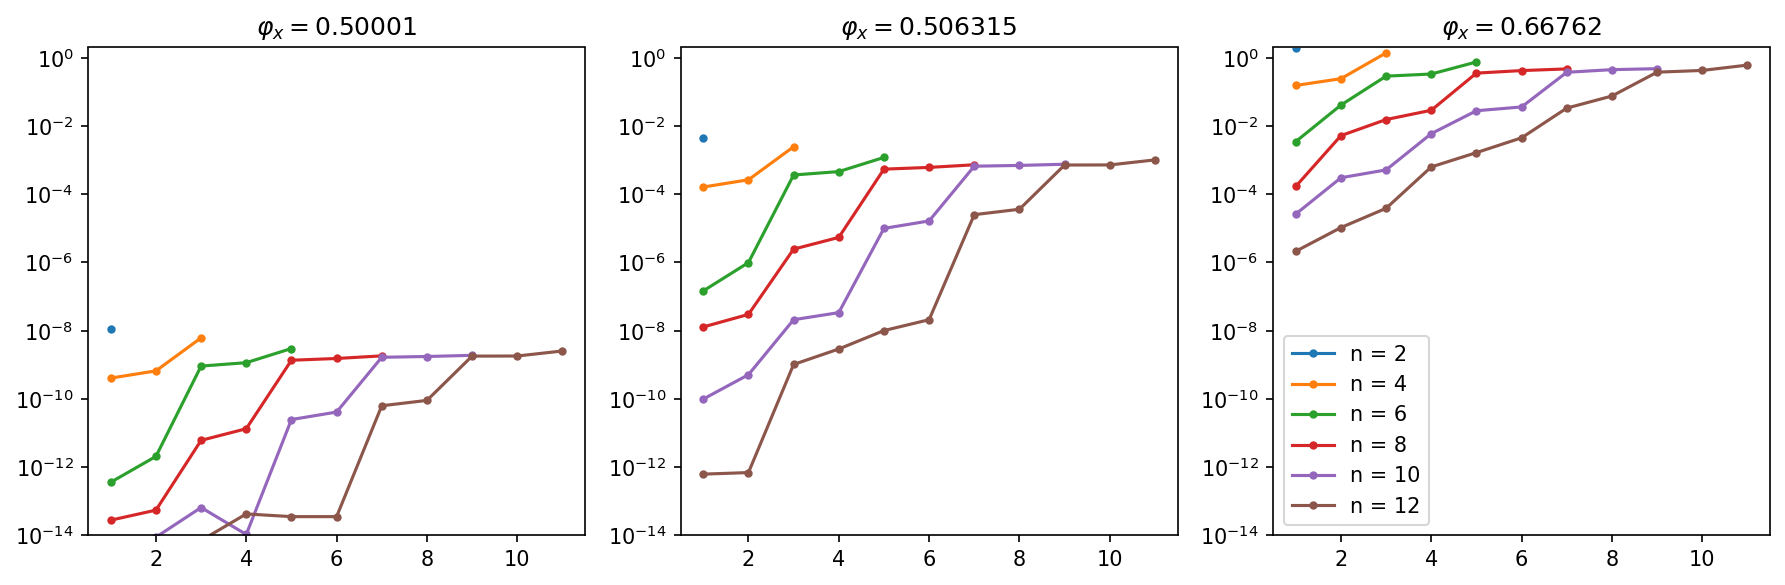

In [319]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

n_basis = np.arange(2, 14, 2)
error_vs_φ_ext = []
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    error=[]
    for n in n_basis:
        E_in_ψ0 = sq_ext.diag(H_in_ψ0[φ_ext_index,:n,:n],n,solver='numpy', out=None,remove_ground=True)[0]
        error.append(np.abs(E_in_ψ0[1:]-E[φ_ext_index,1:n]))
        ax.plot(np.arange(1,n), np.abs(E_in_ψ0[1:]-E[φ_ext_index,1:n]),'.-', label=f'n = {n}')
        
        ax.set_yscale('log')
        ax.set_ylim([1e-14,2])
        ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    error_vs_φ_ext.append(error) 
ax.legend()
fig.tight_layout()

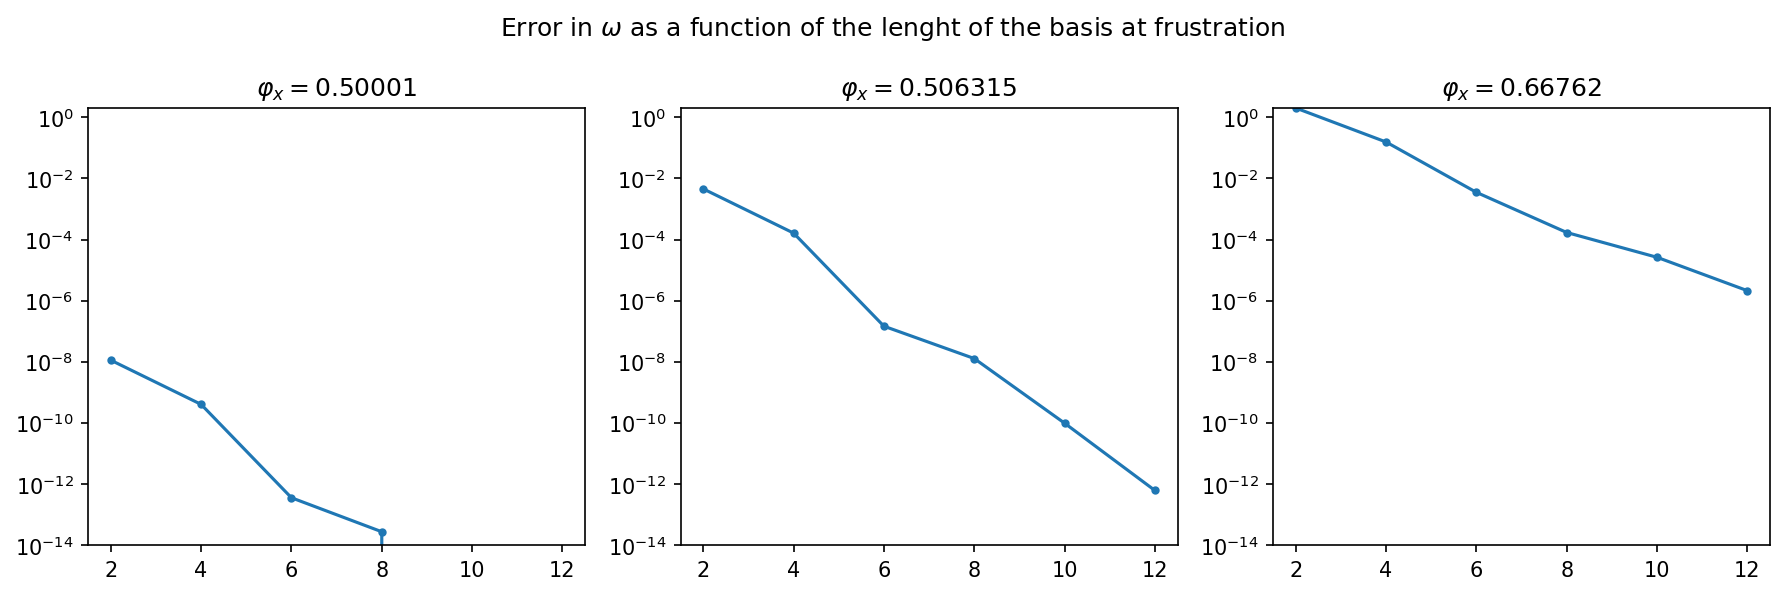

In [320]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for  ax, φ_ext_index, error  in zip(axs, φ_ext_indices, error_vs_φ_ext):
    error_ω = [error_i[0] for error_i in error]
    ax.plot(n_basis,error_ω, '.-')
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    ax.set_yscale('log')
    ax.set_ylim([1e-14,2])

fig.suptitle('Error in $\omega$ as a function of the lenght of the basis at frustration')
fig.tight_layout()